# Projeto Pratico II (SAD) - Mineracao de Dados

**Disciplina:** Sistemas de Apoio a Decisao  
**Autores:** Nahan Rezende e Iasmin Ghirlinzone

**Trabalho:** Projeto Pratico II (Mineracao de Dados)  
**Dataset:** `Crimes_-_2001_to_Present.csv` (Chicago Crimes)  **Link de Download:** https://www.kaggle.com/datasets/utkarshx27/crimes-2001-to-present?utm_source=chatgpt.com

**Tarefa escolhida:** Classificacao  
**Objetivo do modelo:** Predizer se uma ocorrencia resulta em prisao (`Arrest`)

---

## Resumo do que este notebook entrega

- Caracterizacao da base de dados
- Definicao e motivacao do problema
- Pre-processamento dos dados
- Treinamento de algoritmos de classificacao
- Avaliacao com **precisao, revocacao, f1-score e matriz de confusao**
- Analise interpretativa dos resultados (texto gerado no proprio notebook)

> Observacao: o CSV original e muito grande (~1.8 GB). Por isso, o notebook trabalha com amostragem controlada para viabilizar execucao local/Colab.

## 1. Motivacao e definicao do problema

A base de crimes de Chicago contem registros historicos de ocorrencias policiais com atributos como tipo de crime, local, data/horario, distrito e informacoes geograficas.

**Problema proposto (classificacao binaria):**
- Dado um registro de ocorrencia, prever o rotulo `Arrest` (`true` ou `false`).

**Justificativa da escolha:**
- O atributo `Arrest` funciona como alvo supervisionado bem definido.
- O problema e relevante para analise operacional e entendimento de padroes de ocorrencias.
- Permite aplicar tecnicas de classificacao e medir desempenho com as metricas exigidas no enunciado.

**Hipotese inicial:**
- Caracteristicas como tipo de crime, local da ocorrencia, horario, distrito e indicador de violencia domestica podem influenciar a chance de prisao.

## 2. Ambiente e bibliotecas

Se estiver executando no Google Colab e alguma biblioteca faltar, descomente a linha abaixo:

```python
# !pip install pandas numpy matplotlib seaborn scikit-learn
```

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from textwrap import fill

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

sns.set_theme(style='whitegrid', context='notebook')
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

## 3. Leitura da base e configuracoes de amostragem

Como o arquivo e muito grande, adotamos a estrategia:
- selecionar apenas colunas relevantes ao problema;
- limitar a leitura por `nrows` (ajustavel);
- manter uma amostra suficientemente grande para treinamento e avaliacao.

Se sua maquina/Colab suportar, aumente `N_ROWS`.

In [ ]:
DATA_PATH = Path('Crimes_-_2001_to_Present.csv')
assert DATA_PATH.exists(), f'Arquivo nao encontrado: {DATA_PATH.resolve()}'

# Ajuste de amostragem conforme memoria e tempo disponiveis
N_ROWS = None

USE_COLS = [
    'Date',
    'Primary Type',
    'Description',
    'Location Description',
    'Arrest',
    'Domestic',
    'Beat',
    'District',
    'Community Area',
    'Year',
    'Latitude',
    'Longitude',
]

df = pd.read_csv(
    DATA_PATH,
    usecols=USE_COLS,
    nrows=N_ROWS,
    parse_dates=['Date'],
    low_memory=False,
)

# Padronizar colunas booleanas quando necessario
for col in ['Arrest', 'Domestic']:
    if df[col].dtype == 'object':
        df[col] = (
            df[col].astype(str)
            .str.strip()
            .str.lower()
            .map({'true': True, 'false': False})
        )

print(f'Arquivo: {DATA_PATH.name}')
print(f'Linhas lidas: {len(df):,}')
print(f'Colunas selecionadas: {df.shape[1]}')
df.head()

Arquivo: Crimes_-_2001_to_Present.csv
Linhas lidas: 7,784,664
Colunas selecionadas: 12


,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Community Area,Year,Latitude,Longitude
0,2015-09-05 13:30:00,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0000,61.0000,2015,41.8151,-87.6700
1,2015-09-04 11:30:00,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0000,25.0000,2015,41.8951,-87.7654
2,2018-09-01 00:01:00,THEFT,OVER $500,RESIDENCE,False,True,631,6.0000,44.0000,2018,NaN,NaN
3,2015-09-05 12:45:00,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0000,21.0000,2015,41.9374,-87.7166
4,2015-09-05 13:00:00,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0000,25.0000,2015,41.8819,-87.7551


## 4. Caracterizacao da base de dados

Esta secao apresenta:
- dimensoes da amostra;
- tipos de dados;
- valores ausentes;
- distribuicao da variavel-alvo `Arrest`;
- distribuicoes iniciais de atributos relevantes.

In [ ]:
print('Shape da amostra:', df.shape)
display(df.info())

missing = (
    df.isna().sum()
    .sort_values(ascending=False)
    .to_frame('missing')
)
missing['pct'] = 100 * missing['missing'] / len(df)
display(missing)

target_dist = df['Arrest'].value_counts(dropna=False).rename_axis('Arrest').reset_index(name='count')
target_dist['pct'] = 100 * target_dist['count'] / target_dist['count'].sum()
display(target_dist)

Shape da amostra: (7784664, 12)
<class 'pandas.DataFrame'>
RangeIndex: 7784664 entries, 0 to 7784663
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Date                  datetime64[us]
 1   Primary Type          str           
 2   Description           str           
 3   Location Description  str           
 4   Arrest                bool          
 5   Domestic              bool          
 6   Beat                  int64         
 7   District              float64       
 8   Community Area        float64       
 9   Year                  int64         
 10  Latitude              float64       
 11  Longitude             float64       
dtypes: bool(2), datetime64[us](1), float64(4), int64(2), str(3)
memory usage: 608.8 MB


None

,missing,pct
Community Area,613476,7.8806
Latitude,86848,1.1156
Longitude,86848,1.1156
Location Description,10381,0.1334
District,47,0.0006
Description,0,0.0000
Date,0,0.0000
Primary Type,0,0.0000
Beat,0,0.0000
Domestic,0,0.0000


,Arrest,count,pct
0,False,5749900,73.8619
1,True,2034764,26.1381


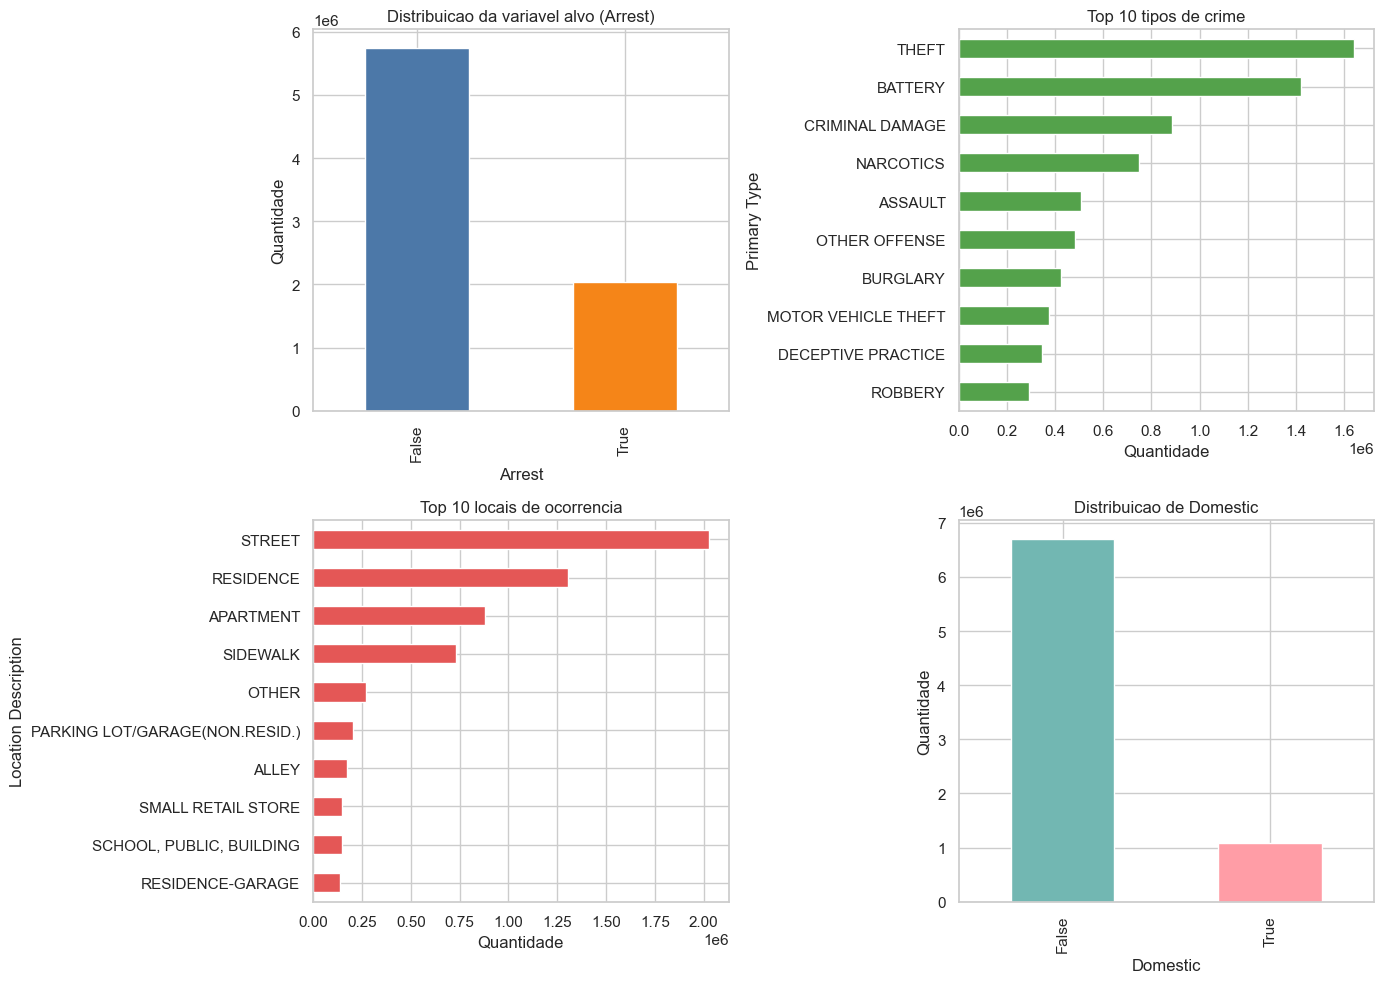

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# 1) Distribuicao do alvo
df['Arrest'].value_counts(dropna=False).plot(kind='bar', ax=axes[0], color=['#4c78a8', '#f58518'])
axes[0].set_title('Distribuicao da variavel alvo (Arrest)')
axes[0].set_xlabel('Arrest')
axes[0].set_ylabel('Quantidade')

# 2) Top tipos de crime
df['Primary Type'].value_counts().head(10).sort_values().plot(kind='barh', ax=axes[1], color='#54a24b')
axes[1].set_title('Top 10 tipos de crime')
axes[1].set_xlabel('Quantidade')

# 3) Top locais de ocorrencia
df['Location Description'].value_counts().head(10).sort_values().plot(kind='barh', ax=axes[2], color='#e45756')
axes[2].set_title('Top 10 locais de ocorrencia')
axes[2].set_xlabel('Quantidade')

# 4) Distribuicao de Domestic
df['Domestic'].value_counts(dropna=False).plot(kind='bar', ax=axes[3], color=['#72b7b2', '#ff9da6'])
axes[3].set_title('Distribuicao de Domestic')
axes[3].set_xlabel('Domestic')
axes[3].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

### 4.1 Analise temporal e relacao com prisao

A extraÃƒÆ’Ã‚Â§ÃƒÆ’Ã‚Â£o de atributos temporais pode aumentar o poder preditivo do modelo.
Vamos observar padroes por hora, dia da semana e mes.

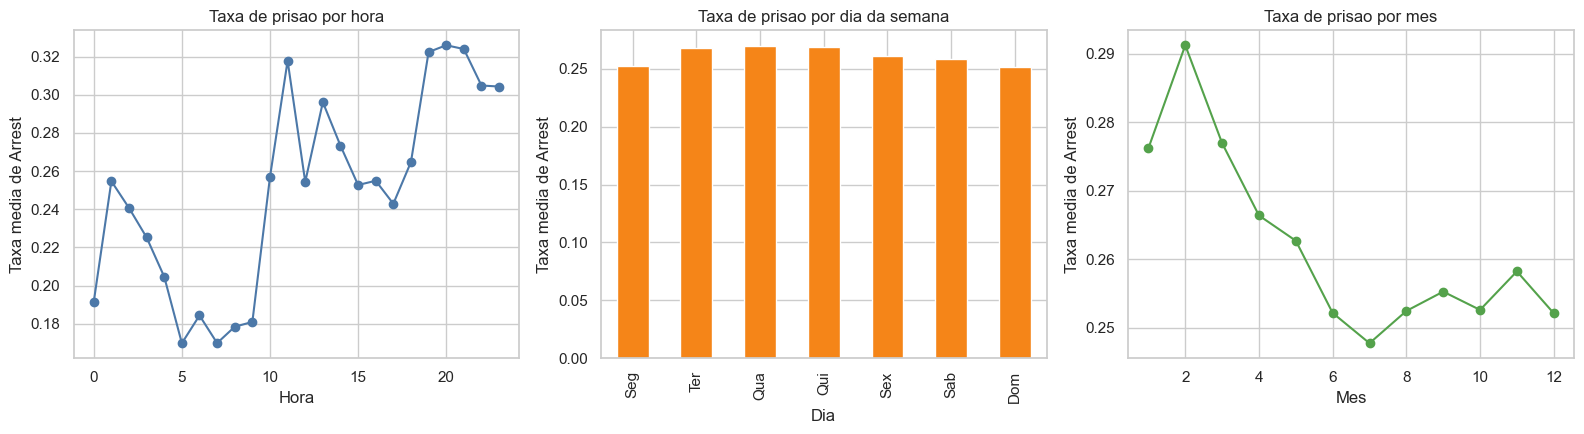

In [ ]:
eda = df.copy()
eda = eda[eda['Date'].notna() & eda['Arrest'].notna()].copy()

eda['Hour'] = eda['Date'].dt.hour
eda['Month'] = eda['Date'].dt.month
eda['DayOfWeek'] = eda['Date'].dt.dayofweek
day_map = {0:'Seg',1:'Ter',2:'Qua',3:'Qui',4:'Sex',5:'Sab',6:'Dom'}
eda['DayOfWeekName'] = eda['DayOfWeek'].map(day_map)

hour_rate = eda.groupby('Hour')['Arrest'].mean()
dow_order = ['Seg','Ter','Qua','Qui','Sex','Sab','Dom']
dow_rate = eda.groupby('DayOfWeekName')['Arrest'].mean().reindex(dow_order)
month_rate = eda.groupby('Month')['Arrest'].mean()

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
hour_rate.plot(ax=axes[0], marker='o', color='#4c78a8')
axes[0].set_title('Taxa de prisao por hora')
axes[0].set_xlabel('Hora')
axes[0].set_ylabel('Taxa media de Arrest')

dow_rate.plot(kind='bar', ax=axes[1], color='#f58518')
axes[1].set_title('Taxa de prisao por dia da semana')
axes[1].set_xlabel('Dia')
axes[1].set_ylabel('Taxa media de Arrest')

month_rate.plot(ax=axes[2], marker='o', color='#54a24b')
axes[2].set_title('Taxa de prisao por mes')
axes[2].set_xlabel('Mes')
axes[2].set_ylabel('Taxa media de Arrest')

plt.tight_layout()
plt.show()

,qtd,taxa_prisao
Primary Type,,
THEFT,1642148,0.1118
BATTERY,1422913,0.2200
CRIMINAL DAMAGE,887266,0.0671
NARCOTICS,747633,0.9939
ASSAULT,507296,0.2124
OTHER OFFENSE,483642,0.1757
BURGLARY,424397,0.0571
MOTOR VEHICLE THEFT,375495,0.0823
DECEPTIVE PRACTICE,344940,0.1344


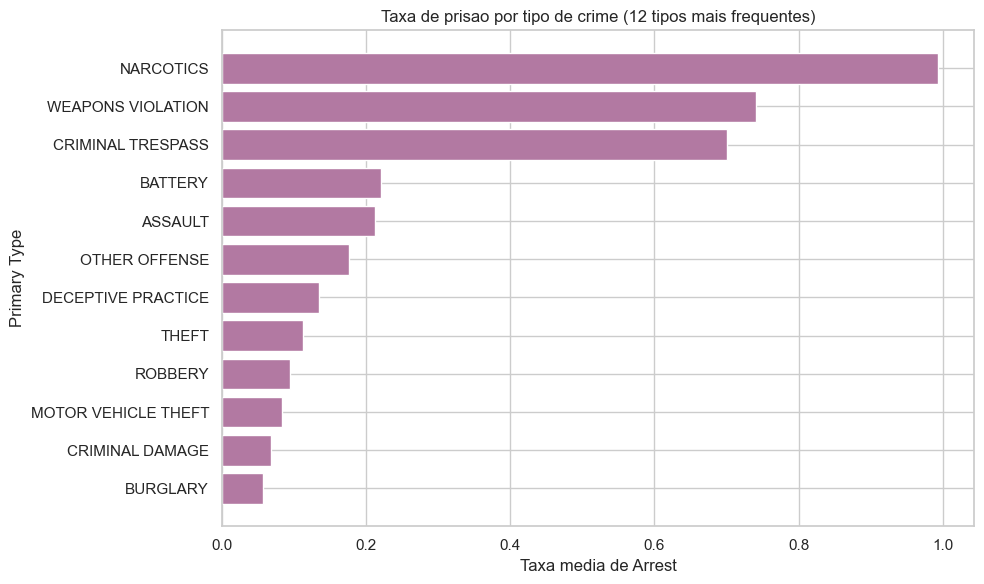

In [ ]:
# Relacao entre tipo de crime e probabilidade media de prisao (top categorias)
type_stats = (
    eda.groupby('Primary Type')
    .agg(qtd=('Arrest','size'), taxa_prisao=('Arrest','mean'))
    .sort_values('qtd', ascending=False)
)
display(type_stats.head(15))

top_types = type_stats.head(12).index
plot_df = type_stats.loc[top_types].sort_values('taxa_prisao')

plt.figure(figsize=(10, 6))
plt.barh(plot_df.index, plot_df['taxa_prisao'], color='#b279a2')
plt.title('Taxa de prisao por tipo de crime (12 tipos mais frequentes)')
plt.xlabel('Taxa media de Arrest')
plt.ylabel('Primary Type')
plt.tight_layout()
plt.show()

## 5. Preparacao dos dados para modelagem

Nesta etapa:
- removemos registros sem alvo (`Arrest`);
- criamos atributos temporais (`Hour`, `Month`, `DayOfWeek`);
- definimos variaveis categoricas e numericas;
- separamos treino e teste com estratificacao.

In [ ]:
df_model = df.copy()
df_model = df_model[df_model['Arrest'].notna()].copy()

# Engenharia de atributos temporais
df_model['Hour'] = df_model['Date'].dt.hour
df_model['Month'] = df_model['Date'].dt.month
df_model['DayOfWeek'] = df_model['Date'].dt.dayofweek

# Remove data bruta apos extrair informacao temporal
df_model = df_model.drop(columns=['Date'])

TARGET_COL = 'Arrest'
y = df_model[TARGET_COL].astype(int)
X = df_model.drop(columns=[TARGET_COL])

categorical_features = [
    'Primary Type', 'Description', 'Location Description',
    'Domestic', 'Beat', 'District', 'Community Area'
]
numeric_features = ['Year', 'Latitude', 'Longitude', 'Hour', 'Month', 'DayOfWeek']

categorical_features = [c for c in categorical_features if c in X.columns]
numeric_features = [c for c in numeric_features if c in X.columns]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y,
)

print('Treino:', X_train.shape, '| Teste:', X_test.shape)
print('Classe positiva (Arrest=1) - treino:', round(y_train.mean(), 4))
print('Classe positiva (Arrest=1) - teste :', round(y_test.mean(), 4))
print('Atributos categoricos:', categorical_features)
print('Atributos numericos  :', numeric_features)

Treino: (6227731, 13) | Teste: (1556933, 13)
Classe positiva (Arrest=1) - treino: 0.2614
Classe positiva (Arrest=1) - teste : 0.2614
Atributos categoricos: ['Primary Type', 'Description', 'Location Description', 'Domestic', 'Beat', 'District', 'Community Area']
Atributos numericos  : ['Year', 'Latitude', 'Longitude', 'Hour', 'Month', 'DayOfWeek']


## 6. Modelagem

Serao treinados dois modelos para comparacao:

1. **Baseline (`DummyClassifier`)** - referencia simples (estrategia mais frequente).
2. **Regressao Logistica** - modelo supervisionado para classificacao binaria com pipeline de pre-processamento.

A comparacao ajuda a demonstrar se o modelo realmente aprende padroes uteis, e nao apenas reproduz a classe majoritaria.

In [ ]:
X_train = X_train.copy()
X_test = X_test.copy()

# Categóricas: manter como object e preservar missing como np.nan (evita pd.NA)
for c in categorical_features:
    if c in X_train.columns:
        X_train[c] = X_train[c].astype("object")
        X_train[c] = X_train[c].where(pd.notna(X_train[c]), np.nan)
    if c in X_test.columns:
        X_test[c] = X_test[c].astype("object")
        X_test[c] = X_test[c].where(pd.notna(X_test[c]), np.nan)

# Numéricas: forçar numérico
for c in numeric_features:
    if c in X_train.columns:
        X_train[c] = pd.to_numeric(X_train[c], errors="coerce")
    if c in X_test.columns:
        X_test[c] = pd.to_numeric(X_test[c], errors="coerce")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)

dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)
dummy_pred = dummy_model.predict(X_test)

logreg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')),
])

logreg_model.fit(X_train, y_train)
logreg_pred = logreg_model.predict(X_test)

print('Modelos treinados com sucesso.')


Modelos treinados com sucesso.


## 7. Avaliacao dos resultados (metricas exigidas no enunciado)

Metricas apresentadas:
- Precisao
- Revocacao
- F1-score
- Matriz de confusao

Tambem incluimos `accuracy` e comparacao com baseline para enriquecer a analise.

,modelo,accuracy,precisao,revocacao,f1_score
1,Regressao Logistica,0.8566,0.7179,0.7434,0.7304
0,Dummy (classe majoritaria),0.7386,0.0000,0.0000,0.0000


<Figure size 900x450 with 0 Axes>

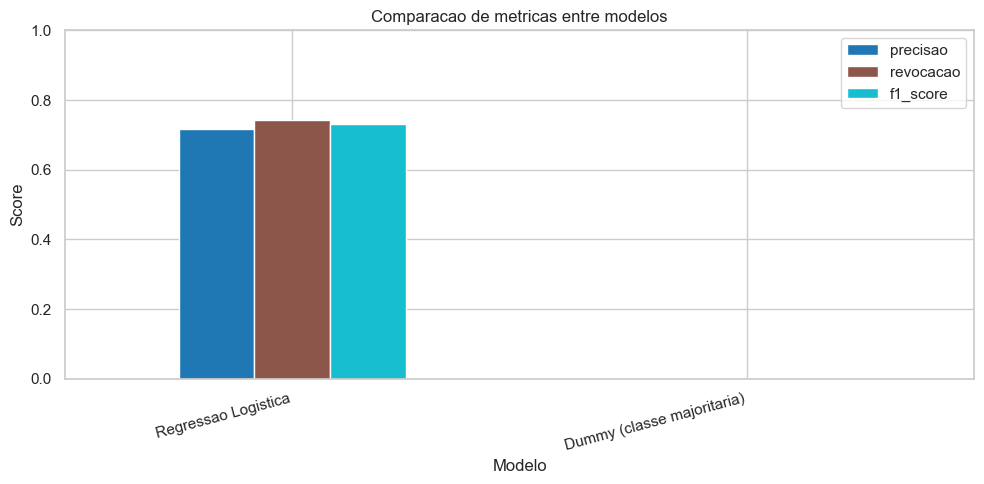

In [ ]:
def compute_metrics(y_true, y_pred, model_name):
    return {
        'modelo': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precisao': precision_score(y_true, y_pred, zero_division=0),
        'revocacao': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
    }

results = pd.DataFrame([
    compute_metrics(y_test, dummy_pred, 'Dummy (classe majoritaria)'),
    compute_metrics(y_test, logreg_pred, 'Regressao Logistica'),
]).sort_values('f1_score', ascending=False)

display(results)

plt.figure(figsize=(9, 4.5))
plot_cols = ['precisao', 'revocacao', 'f1_score']
plot_df = results.set_index('modelo')[plot_cols]
plot_df.plot(kind='bar', figsize=(10, 5), colormap='tab10')
plt.title('Comparacao de metricas entre modelos')
plt.ylabel('Score')
plt.xlabel('Modelo')
plt.xticks(rotation=15, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Relatorio de classificacao - Regressao Logistica
              precision    recall  f1-score   support

           0     0.9080    0.8966    0.9023   1149980
           1     0.7179    0.7434    0.7304    406953

    accuracy                         0.8566   1556933
   macro avg     0.8130    0.8200    0.8164   1556933
weighted avg     0.8583    0.8566    0.8574   1556933



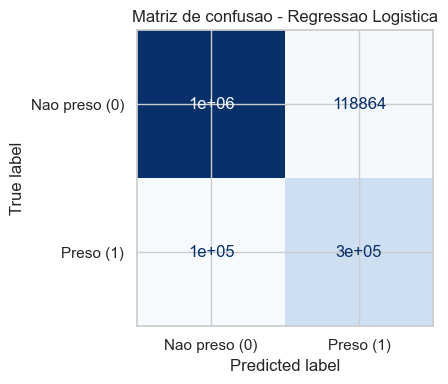

In [ ]:
print('Relatorio de classificacao - Regressao Logistica')
print(classification_report(y_test, logreg_pred, digits=4, zero_division=0))

cm = confusion_matrix(y_test, logreg_pred)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nao preso (0)', 'Preso (1)'])
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Matriz de confusao - Regressao Logistica')
plt.tight_layout()
plt.show()

## 8. Analise interpretativa automatizada (texto pronto para a entrega)

A celula abaixo gera um resumo textual com base nas metricas obtidas. Esse texto pode ser aproveitado na entrega e nos slides.

In [ ]:
res = results.set_index('modelo')
best_model = res['f1_score'].idxmax()
best = res.loc[best_model]
baseline = res.loc['Dummy (classe majoritaria)'] if 'Dummy (classe majoritaria)' in res.index else None

target_pct = y.mean() * 100
class_balance_txt = (
    f'A proporcao de casos com prisao (Arrest=1) na amostra utilizada e de aproximadamente {target_pct:.2f}%. '
    'Isso indica o grau de desbalanceamento da classe e ajuda a interpretar as metricas.'
)

comparison_txt = ''
if baseline is not None:
    diff_f1 = best['f1_score'] - baseline['f1_score']
    diff_recall = best['revocacao'] - baseline['revocacao']
    comparison_txt = (
        f'Comparado ao baseline, o melhor modelo apresentou variacao de {diff_f1:.4f} em F1-score '
        f'e {diff_recall:.4f} em revocacao.'
    )

quality_txt = []
if best['f1_score'] >= 0.75:
    quality_txt.append('O F1-score sugere desempenho forte para este recorte da base.')
elif best['f1_score'] >= 0.55:
    quality_txt.append('O F1-score indica desempenho moderado, com espaco para melhorias.')
else:
    quality_txt.append('O F1-score indica desempenho limitado, sugerindo necessidade de melhorias no modelo e/ou atributos.')

if best['revocacao'] < 0.50:
    quality_txt.append('A revocacao baixa significa que muitos casos com prisao podem estar sendo perdidos.')
elif best['revocacao'] > 0.75:
    quality_txt.append('A revocacao elevada mostra boa capacidade de identificar casos com prisao.')

if best['precisao'] < 0.50:
    quality_txt.append('A precisao baixa indica maior quantidade de falsos positivos entre previsoes de prisao.')
elif best['precisao'] > 0.75:
    quality_txt.append('A precisao elevada indica que boa parte das previsoes de prisao esta correta.')

analysis_lines = [
    'ANALISE AUTOMATICA DOS RESULTADOS',
    '-' * 40,
    f'Melhor modelo (por F1-score): {best_model}',
    f'Accuracy : {best['accuracy']:.4f}',
    f'Precisao : {best['precisao']:.4f}',
    f'Revocacao: {best['revocacao']:.4f}',
    f'F1-score : {best['f1_score']:.4f}',
    '',
    class_balance_txt,
    comparison_txt,
    *quality_txt,
    '',
    'Interpretacao geral: o modelo busca aprender padroes associados a prisao a partir de tipo de crime, local, distrito e horario. ',
    'O resultado deve ser analisado em conjunto com o desbalanceamento das classes e com a qualidade/ausencia de atributos no dataset.'
]

for line in analysis_lines:
    if isinstance(line, str) and len(line) > 120:
        print(fill(line, width=120))
    else:
        print(line)

ANALISE AUTOMATICA DOS RESULTADOS
----------------------------------------
Melhor modelo (por F1-score): Regressao Logistica
Accuracy : 0.8566
Precisao : 0.7179
Revocacao: 0.7434
F1-score : 0.7304

A proporcao de casos com prisao (Arrest=1) na amostra utilizada e de aproximadamente 26.14%. Isso indica o grau de
desbalanceamento da classe e ajuda a interpretar as metricas.
Comparado ao baseline, o melhor modelo apresentou variacao de 0.7304 em F1-score e 0.7434 em revocacao.
O F1-score indica desempenho moderado, com espaco para melhorias.

Interpretacao geral: o modelo busca aprender padroes associados a prisao a partir de tipo de crime, local, distrito e
horario.
O resultado deve ser analisado em conjunto com o desbalanceamento das classes e com a qualidade/ausencia de atributos no
dataset.


## 9. Conclusao

Este notebook implementa uma solucao de **classificacao** para o dataset de crimes de Chicago, atendendo aos requisitos centrais do Projeto Pratico II:

- caracterizacao da base de dados;
- definicao do problema e motivacao;
- aplicacao de algoritmo de mineracao de dados (classificacao);
- avaliacao com **precisao, revocacao, f1-score e matriz de confusao**;
- analise dos resultados obtidos.

Com a execucao completa deste notebook e a preparacao dos slides, o material fica pronto para apresentacao e entrega.